# Training Dynamic Visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pickle
import subprocess
import sys
from dataclasses import dataclass
from pathlib import Path


import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import rc
from tqdm import tqdm

sys.path.append(str(Path("..").resolve()))

from models.mlp import TransformerFeedForward
from models.normalization import RMSNorm

SAVE_DIR = Path(".").resolve() / "results"
DEVICE = torch.device("cuda:0")
SEED = None
SEED = 200
if SEED:
    RNG = np.random.default_rng(SEED)
    np.random.seed(seed=SEED)
    torch.manual_seed(seed=SEED)

rc("font", family="serif", size=8)
usetex = not subprocess.run(["which", "pdflatex"]).returncode
usetex = False
rc("text", usetex=usetex)
if usetex:
    rc("text.latex", preamble=r"\usepackage{times}")


/usr/bin/pdflatex


## Data Generation

In [3]:
vocab_size = 2
# vocab_size = 4
bsz = 2048
length = 12
sparsity_index = 5

# modular addition problem on some subset of the input only
data = np.random.rand(bsz, length) // (1 / vocab_size)
targets = data[:, :sparsity_index].sum(axis=1) % vocab_size

test_bsz = 128
test_data = np.random.rand(test_bsz, length) // (1 / vocab_size)
test_targets = test_data[:, :sparsity_index].sum(axis=1) % vocab_size

In [4]:
print(f"Total number of unique sequences {vocab_size ** length}")

Total number of unique sequences 4096


## Model

In [5]:
class SoftmaxLayer(nn.Module):
    def __init__(self, emb_dim):
        super(SoftmaxLayer, self).__init__()
        self.emb_dim = emb_dim
        self.query = nn.Linear(emb_dim, 1, bias=False)
        self.value = nn.Linear(emb_dim, emb_dim, bias=False)

    def forward(self, x, verbose=False):
        # x: [bsz, seq_len, emb_dim]
        query = self.query.weight
        key = x
        value = self.value(x)

        attn = query @ key.transpose(-1, -2) / math.sqrt(self.emb_dim)
        attn = F.softmax(attn, dim=-1)
        out = (attn @ value).squeeze(1)
        if verbose:
            return out, attn.squeeze(1)
        return out

In [6]:
@dataclass
class MLPConfig:
    activation: float = "gelu"
    emb_dim: bool = None
    ffn_dim: bool = None
    ffn_bias: bool = False
    ffn_dropout: float = 0

    def __post_init__(self):
        if self.ffn_dim is None:
            self.ffn_dim = 4 * self.emb_dim


class Model(nn.Module):
    def __init__(self, emb_dim, vocab_size, ffn_dim=None):
        if ffn_dim is None:
            ffn_dim = 4 * emb_dim
        super(Model, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = nn.Embedding(length, emb_dim)

        self.softmax = SoftmaxLayer(emb_dim)
        config = MLPConfig(
            emb_dim=emb_dim,
            ffn_dim=ffn_dim,
            ffn_bias=True,
            activation="gelu",
        )
        self.mlp = TransformerFeedForward(config)

        self.output = nn.Linear(emb_dim, vocab_size, bias=False)
        self.output.weight = self.token_emb.weight

        self.norm1 = RMSNorm()
        self.norm2 = RMSNorm()

    def forward(self, x, verbose=False):
        out = self.token_emb(x) + self.pos_emb.weight
        out = self.softmax(self.norm1(out), verbose=verbose)
        if verbose:
            out, attn = out
        out = out + self.mlp(self.norm2(out))
        out = self.output(out)
        if verbose:
            return out, attn
        return out

In [7]:
emb_dim = 2
# ffn_dim = 4 * emb_dim
ffn_dim = 10
vocab_size = 2
torch.manual_seed(20)

model = Model(emb_dim=emb_dim, vocab_size=vocab_size, ffn_dim=ffn_dim)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

model.to(device=DEVICE)

Number of parameters: 86


Model(
  (token_emb): Embedding(2, 2)
  (pos_emb): Embedding(12, 2)
  (softmax): SoftmaxLayer(
    (query): Linear(in_features=2, out_features=1, bias=False)
    (value): Linear(in_features=2, out_features=2, bias=False)
  )
  (mlp): TransformerFeedForward(
    (fc1): Linear(in_features=2, out_features=10, bias=True)
    (fc2): Linear(in_features=10, out_features=2, bias=True)
  )
  (output): Linear(in_features=2, out_features=2, bias=False)
  (norm1): RMSNorm()
  (norm2): RMSNorm()
)

## Training loop

In [8]:
niter = 2_000 # 2

X = torch.from_numpy(data).to(dtype=torch.long, device=DEVICE)
Y = torch.from_numpy(targets).to(dtype=torch.long, device=DEVICE)

X_test = torch.from_numpy(test_data).to(dtype=torch.long, device=DEVICE)
Y_test = torch.from_numpy(test_targets).to(dtype=torch.long, device=DEVICE)

# optimizer
lambda_l1 = 1e-4
lr = 1e-2 # emb_dim == 2 & ffn_dim == 32 & reg_l1 & model_seed 20
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

losses = torch.zeros(niter)
test_losses = torch.zeros(niter)
accs = torch.zeros(niter)
test_accs = torch.zeros(niter)

weights = [{k: v.cpu().detach() for k, v in model.state_dict().items()}]

for i in (bar := tqdm(range(niter))):
    optimizer.zero_grad()

    # compute loss
    score = model(X, verbose=False)
    loss = F.cross_entropy(score.view((-1, vocab_size)), Y.view(-1))
    reg_loss = lambda_l1 * sum(p.abs().sum() for p in model.parameters())

    loss.backward()
    reg_loss.backward()
    optimizer.step()

    # record statistics
    with torch.no_grad():
        losses[i] = loss.item()
        accs[i] = (score.argmax(-1) == Y).float().mean()
        score_test = model(X_test)
        test_losses[i] = F.cross_entropy(score_test.view((-1, vocab_size)), Y_test.view(-1))
        test_accs[i] = (score_test.argmax(-1) == Y_test).float().mean()
        weights.append({k: v.cpu().detach() for k, v in model.state_dict().items()})
    
    bar.set_postfix(loss=losses[i].item(), acc=accs[i].item(), test_acc=test_accs[i].item())

100%|██████████| 2000/2000 [00:14<00:00, 133.90it/s, acc=1, loss=0.00355, test_acc=1]      


In [9]:
pickle.dump(weights, open(SAVE_DIR / "weights.pkl", "wb"))

## Accuracy

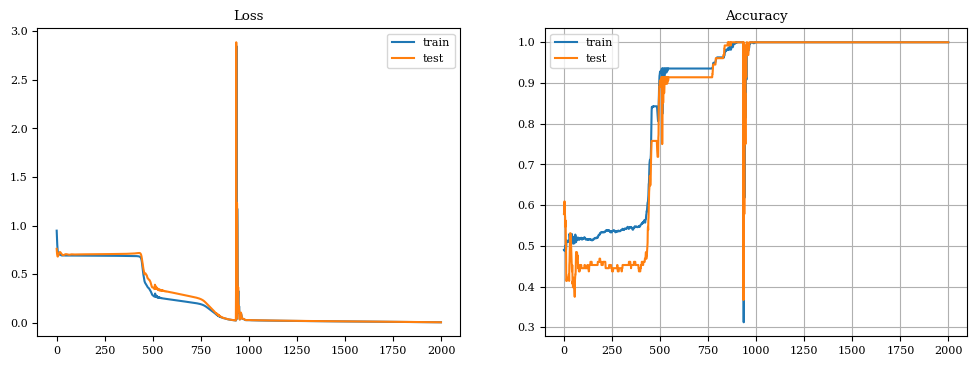

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses, label="train")
axes[0].plot(test_losses, label="test")
axes[0].set_title("Loss")
axes[0].legend()
axes[1].plot(accs, label="train")
axes[1].plot(test_accs, label="test")
axes[1].set_title("Accuracy")
axes[1].legend()
axes[1].grid()

## Visualization of the dynamics

In [11]:
DEVICE = 'cpu'
weights = pickle.load(open(SAVE_DIR / "weights.pkl", "rb"))

In [12]:
# data
prefix = [
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 1],
    [0, 1, 1, 0, 0],
    [0, 0, 1, 1, 1],
    [0, 1, 1, 0, 1],
    [0, 1, 1, 1, 1],
    [1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1],
]
suffixes = [
    [0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 1],
    [0, 1, 1, 0, 0, 1, 0],
]
inputs = torch.tensor([
    pre + suf for pre in prefix for suf in suffixes
], device=DEVICE)

tmpx = torch.linspace(-1, 1, 50)
tmpy = torch.linspace(-.5, .5, 50)
X, Y = torch.meshgrid(tmpx, tmpy)
grid = torch.stack([X, Y], dim=-1).reshape(-1, 2).to(DEVICE)

# modules
model.to(DEVICE)
norm = RMSNorm()

/private/home/vivc/miniconda/envs/dev/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
WIDTH = 15
HEIGHT = 15

fig, axes = plt.subplots(3, 3, figsize=(WIDTH, HEIGHT))

text_fontsize=8
title_fontsize=12

def update(frame):
    for i in range(3):
        for j in range(3):
            axes[i, j].clear()

    token_emb = weights[frame]['token_emb.weight']
    pos_emb = weights[frame]['pos_emb.weight']
    emb = (token_emb.unsqueeze(1) + pos_emb).reshape(-1, 2)
    norm_emb = norm(emb)

    query = weights[frame]['softmax.query.weight']
    value = weights[frame]['softmax.value.weight']
    emb_val = norm_emb @ value.T

    model.load_state_dict(weights[frame])
    with torch.no_grad():
        seq_emb = model.softmax(model.norm1(model.token_emb(inputs) + model.pos_emb.weight))
        seq_mlp = seq_emb + model.mlp(model.norm2(seq_emb))
        outputs = F.softmax(model.output(grid + model.mlp(norm(grid))), dim=-1)[:, 1]
        seq_prob = F.softmax(model.output(seq_mlp), dim=-1)

    axes[0, 0].scatter(token_emb[:, 0], token_emb[:, 1], c=np.arange(token_emb.shape[0]), cmap='tab20', s=100)
    for i, (x, y) in enumerate(token_emb):
        axes[0, 0].text(x, y, i, fontsize=text_fontsize)
    axes[0, 0].set_title("Token Embeddings", fontsize=title_fontsize)

    axes[0, 1].scatter(pos_emb[:, 0], pos_emb[:, 1], c=np.arange(pos_emb.shape[0]), cmap='tab20', s=100)
    for i, (x, y) in enumerate(pos_emb):
        axes[0, 1].text(x, y, i, fontsize=text_fontsize)
    axes[0, 1].set_title("Position Embeddings", fontsize=title_fontsize)

    axes[0, 2].scatter(emb[:, 0], emb[:, 1], c=np.arange(emb.shape[0]), cmap='tab20', s=100)
    for i, (x, y) in enumerate(emb):
        axes[0, 2].text(x, y, (i // 12, i % 12), fontsize=text_fontsize)
    axes[0, 2].set_title("Embeddings", fontsize=title_fontsize)

    axes[1, 0].scatter(norm_emb[:, 0], norm_emb[:, 1], c=np.arange(norm_emb.shape[0]), cmap='tab20', s=100)
    for i, (x, y) in enumerate(norm_emb):
        axes[1, 0].text(x, y, (i // 12, i % 12), fontsize=text_fontsize)
    axes[1, 0].arrow(0, 0, query[0, 0], query[0, 1], head_width=0.1, head_length=0.1, fc='r', ec='r')
    axes[1, 0].text(0, 0, "query", fontsize=text_fontsize + 2, color='r')
    axes[1, 0].set_title("Normed Embeddings", fontsize=title_fontsize)

    axes[1, 1].scatter(emb_val[:, 0], emb_val[:, 1], c=np.arange(emb_val.shape[0]), cmap='tab20', s=100)
    for i, (x, y) in enumerate(emb_val):
        axes[1, 1].text(x, y, (i // 12, i % 12), fontsize=text_fontsize)
    axes[1, 1].set_title("Value", fontsize=title_fontsize)

    axes[1, 2].scatter(seq_emb[:, 0], seq_emb[:, 1], c=np.arange(seq_emb.shape[0]), cmap='tab20b', s=100)
    for i, (x, y) in enumerate(seq_emb):
        t = axes[1, 2].text(x, y, inputs[i].numpy().tolist(), fontsize=text_fontsize)
        t.set_alpha(0.3)
    axes[1, 2].set_title("Sequence Embeddings", fontsize=title_fontsize)

    axes[2, 0].scatter(seq_mlp[:, 0], seq_mlp[:, 1], c=np.arange(seq_mlp.shape[0]), cmap='tab20b', s=100)
    for i, (x, y) in enumerate(seq_mlp):
        t = axes[2, 0].text(x, y, inputs[i].numpy().tolist(), fontsize=text_fontsize)
        t.set_alpha(0.3)
    axes[2, 0].set_title("MLP transform", fontsize=title_fontsize)

    axes[2, 1].contourf(X, Y, outputs.reshape(50, 50), cmap='coolwarm', vmin=0, vmax=1)
    axes[2, 1].scatter(seq_mlp[:, 0], seq_mlp[:, 1], c=np.arange(seq_mlp.shape[0]), cmap='tab20b', s=100)
    for i, (x, y) in enumerate(seq_mlp):
        t = axes[2, 1].text(x, y, inputs[i].numpy().tolist(), fontsize=text_fontsize)
        t.set_alpha(0.3)
    axes[2, 1].set_title("MLP level lines", fontsize=title_fontsize)

    axes[2, 2].scatter(seq_prob[:, 0], seq_prob[:, 1], c=np.arange(seq_prob.shape[0]), cmap='tab20b', s=100)
    for i, (x, y) in enumerate(seq_prob):
        t = axes[2, 2].text(x, y, inputs[i].numpy().tolist(), fontsize=text_fontsize)
        t.set_alpha(0.3)
    axes[2, 2].set_title("Output", fontsize=title_fontsize)

length = 2000
block_length = length // 20
for i in range(20):
    ani = animation.FuncAnimation(fig, update, frames=range(i * block_length, (i+1) * block_length), repeat=False)
    ani.save(SAVE_DIR / f"full_{i}.mp4", writer="ffmpeg", fps=20)